In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from PIL import Image

df = pd.read_csv("UsArrests.csv", index_col="City")
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.200,236,58,21.200
Alaska,10.000,263,48,44.500
Arizona,8.100,294,80,31.000
Arkansas,8.800,190,50,19.500
California,9.000,276,91,40.600


## Overview of Dataset

Contains statistics on arrests per 100,000 residents for murder, assault and rape in each of the 50 US states in 1973. Also provided is the percentage of the population living in urban areas.

## Pre-Processing

In [3]:
df.shape

(50, 4)

In [4]:
# Checking for any missing values 
df.isnull().sum()

Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [6]:
# Checking for any other forms of missing values 
df["Murder"].unique
df["Assault"].unique
df["UrbanPop"].unique
df["Rape"].unique

<bound method Series.unique of City
Alabama           21.2
Alaska            44.5
Arizona           31.0
Arkansas          19.5
California        40.6
Colorado          38.7
Connecticut       11.1
Delaware          15.8
Florida           31.9
Georgia           25.8
Hawaii            20.2
Idaho             14.2
Illinois          24.0
Indiana           21.0
Iowa              11.3
Kansas            18.0
Kentucky          16.3
Louisiana         22.2
Maine              7.8
Maryland          27.8
Massachusetts     16.3
Michigan          35.1
Minnesota         14.9
Mississippi       17.1
Missouri          28.2
Montana           16.4
Nebraska          16.5
Nevada            46.0
New Hampshire      9.5
New Jersey        18.8
New Mexico        32.1
New York          26.1
North Carolina    16.1
North Dakota       7.3
Ohio              21.4
Oklahoma          20.0
Oregon            29.3
Pennsylvania      14.9
Rhode Island       8.3
South Carolina    22.5
South Dakota      12.8
Tennessee         26.

In [7]:
# Checking if there are non-numerical features
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


## Inspect the data

In [8]:
# Summary of the dataset
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [9]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


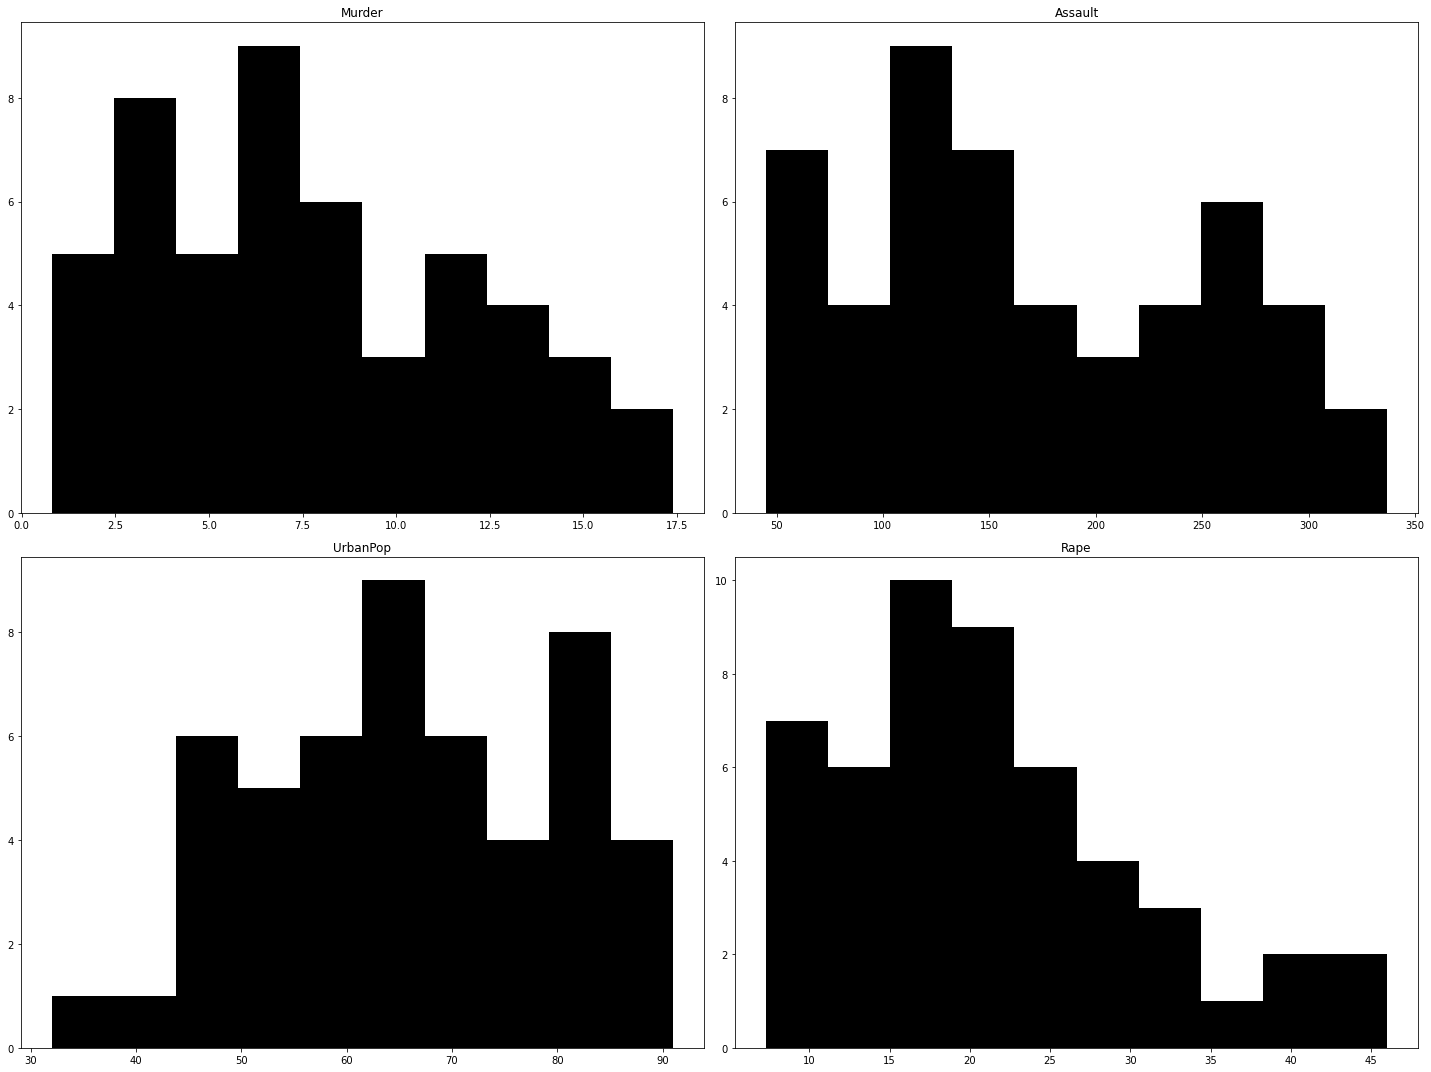

In [10]:
# Checking the distribution of each column variable
histograms = df.hist(color='black', grid=False, figsize=(20, 15)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()

### Correlation Matrix

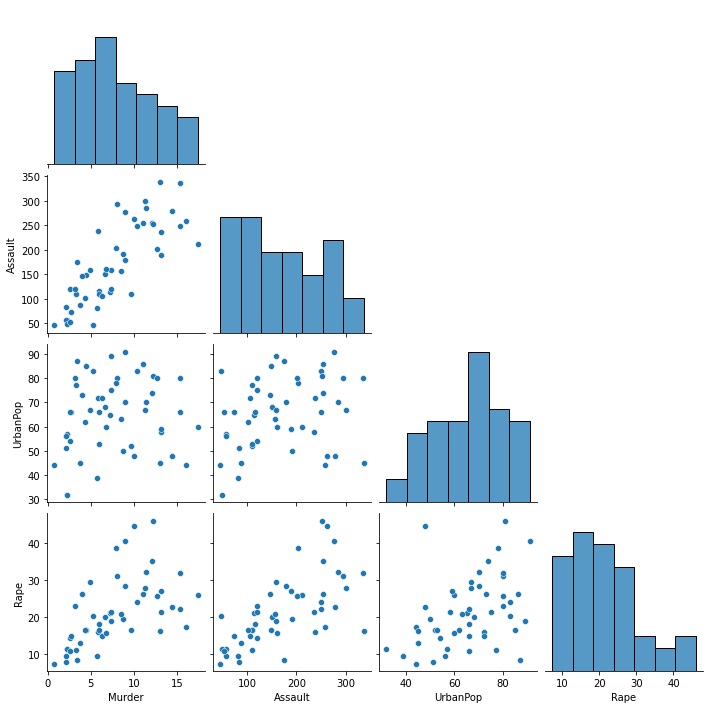

In [11]:
sns.pairplot(df, corner=True)

In [12]:
cities = df.index
corr_df = df.corr()
labels = corr_df.columns

Text(0.5, 1.0, 'Correlation of UsArrest Features')

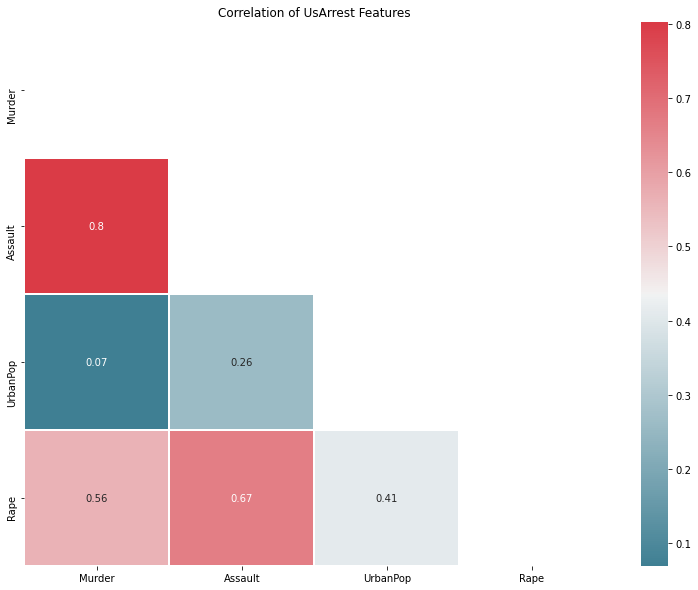

In [13]:
plt.figure(figsize=(13,10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones(corr_df.shape, dtype=bool))
sns.heatmap(corr_df, mask=mask, cmap=colormap,linewidth=1, annot=True)
plt.title("Correlation of UsArrest Features")

From this matrix we can see that at least one feature 'Assault' has a very strong correlation with two features ('Murder' and 'Rape'). Furthermore, 'Rape' also has a strong correlation with three features ('Murder', 'Assault' and 'UrbanPop'). This making this dataset appropriate for Principle Component Analysis (PCA).

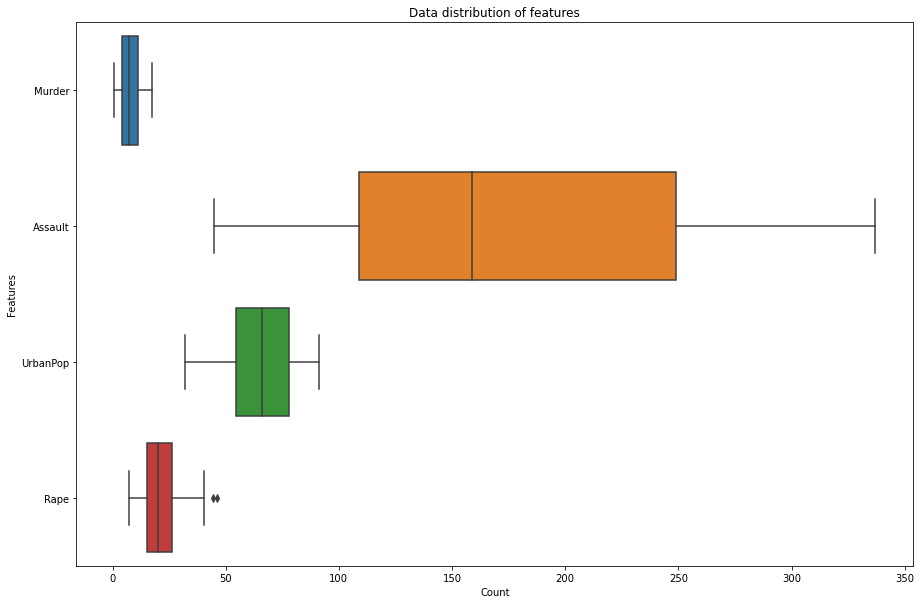

In [14]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df[["Murder", "Assault", "UrbanPop", "Rape"]], orient='h')
plt.ylabel("Features")
plt.xlabel("Count")
plt.title("Data distribution of features")
plt.show()

From the boxplot it can be seen that the values of each feature are dispropotionate to one another, thus for example 'Assault' has a very large
range in comparison to the other three features. Thus, the data will be scaled.

## Apply PCA
### PCA (Not Scaled)

In [18]:
X = df.values.squeeze()
X.shape

(50, 4)

In [20]:
pca = PCA()
X_trans = pca.fit_transform(X)
df_pca = pd.DataFrame(X_trans, columns = df.columns[0:5])
df_pca.head()

,Murder,Assault,UrbanPop,Rape
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


In [21]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73240025 14.21240185  6.48942607  2.48279   ]


In [22]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.65534221e-01 2.78173366e-02 5.79953492e-03 8.48907879e-04]


In [23]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11485102 7213.10721735 7255.2198681  7261.38411429]


In [24]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

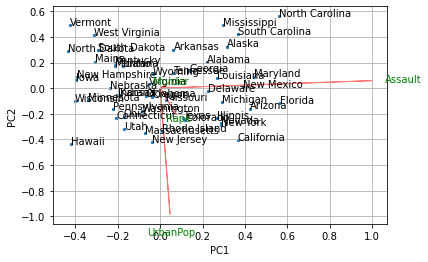

In [25]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(cities))
plt.show()

In [26]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )
pc3 = abs( pca.components_[2] )
pc4 = abs( pca.components_[3] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df["PC3 Importance"] = pc3
feat_df["PC4 Importance"] = pc4
feat_df

,Features,PC1 Importance,PC2 Importance,PC3 Importance,PC4 Importance
0,Murder,0.042,0.045,0.080,0.995
1,Assault,0.995,0.059,0.068,0.039
2,UrbanPop,0.046,0.977,0.201,0.058
3,Rape,0.075,0.201,0.974,0.072


From this bi-plot of the PCA conducted on the raw unscaled data it can be seen that 'Assault' and 'UrbanPop' appear to dominate how a state in classified. Which is corroborated from the table above, as PC1 is mainly influenced by 'Assault' and PC2 by 'UrbanPop' values. However, the scale of these features is not proportionate as 'Assault' is measures in 100,000 and 'UrbanPop' is a percentage.

### PCA (Scaled)

In [29]:
# Standarization 
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [34]:
pca_std = PCA()
X_std_trans = pca_std.fit_transform(X_std)

df_pca_std = pd.DataFrame(X_std_trans, columns = df.columns[0:5])
df_pca_std.head()

,Murder,Assault,UrbanPop,Rape
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


In [35]:
std = df_pca_std.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [1.5908673  1.00496987 0.6031915  0.4206774 ]


In [36]:
print(f"Proportion of Variance Explained: {pca_std.explained_variance_ratio_}")

Proportion of Variance Explained: [0.62006039 0.24744129 0.0891408  0.04335752]


In [37]:
print(f"Cumulative Proportion: {np.cumsum(pca_std.explained_variance_)}")

Cumulative Proportion: [2.53085875 3.5408232  3.90466318 4.08163265]


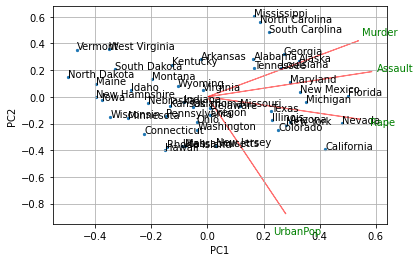

In [38]:
biplot(X_std_trans[:,0:2],np.transpose(pca_std.components_[0:2, :]),list(labels))
plt.show()

In [39]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca_std.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca_std.components_[1] )
pc3 = abs( pca_std.components_[2] )
pc4 = abs( pca_std.components_[3] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df["PC3 Importance"] = pc3
feat_df["PC4 Importance"] = pc4
feat_df

,Features,PC1 Importance,PC2 Importance,PC3 Importance,PC4 Importance
0,Murder,0.536,0.418,0.341,0.649
1,Assault,0.583,0.188,0.268,0.743
2,UrbanPop,0.278,0.873,0.378,0.134
3,Rape,0.543,0.167,0.818,0.089


It can be seen that PC1 is influence almost equally by 'Murder', 'Assault' and 'Rape', whilst PC2 is mainly influenced by 'UrbanPop' and somwhat 'Murder'.

### Scree & Cumulative Explained Variance Plots

In [40]:
covar_matrix = PCA(n_components=len(df.columns))
covar_matrix.fit(X_std)

PCA(n_components=4)

Text(2.5, 1, 'Eigenvalue=1')

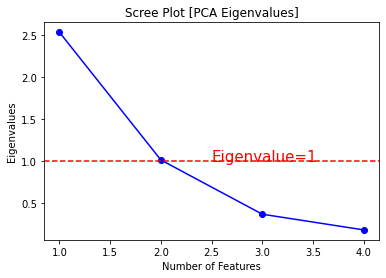

In [41]:
pc_values = np.arange(covar_matrix.n_components_) + 1

plt.plot(pc_values, covar_matrix.explained_variance_, 'o-', color='blue')
plt.title('Scree Plot [PCA Eigenvalues]')
plt.xlabel('Number of Features')
plt.ylabel('Eigenvalues')
plt.axhline(y=1, color='r', linestyle='--')
plt.text(2.5, 1, "Eigenvalue=1", color="red", fontsize=15)

[0.62006039 0.24744129 0.0891408  0.04335752]


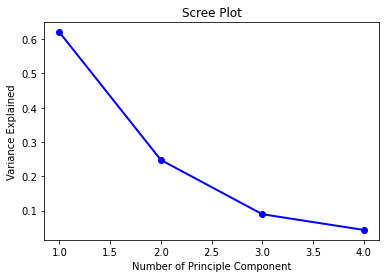

In [42]:
pca_tot = PCA(n_components=4)
pca_tot.fit(X_std)
pc_values = np.arange(pca_tot.n_components_) + 1

plt.plot(pc_values, pca_tot.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Number of Principle Component')
plt.ylabel('Variance Explained')

print(pca_tot.explained_variance_ratio_)

Text(2, 80, '80% threshold')

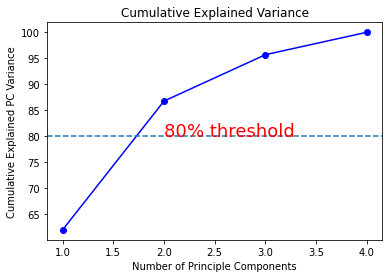

In [43]:
culvar = covar_matrix.explained_variance_ratio_ + 1
cv = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, 3)*100)

plt.plot(pc_values, cv, 'o-', color='blue')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principle Components')
plt.ylabel('Cumulative Explained PC Variance')
plt.axhline(y=80, linestyle='--')
plt.text(2, 80, "80% threshold", color="red", fontsize=18)

The first two Principle Componenets explain around 87% of the variance in the data which is greater than the standard of 80%. Thus, the number of Principle Components that will be used will be 2.

### PCA @ n_comp=2

In [44]:
# choose number of components to be generated
n_comps = 2
pca = PCA(n_components=n_comps)

# obtain components
principal_components = pca.fit_transform(X_std)

# naming PC columns
columns = ['PC 1', 'PC 2']

# transform the components into a pandas data frame
pca_df = pd.DataFrame(principal_components, columns = columns)

# This is to include the plant id's as the row names in the PC'S
pca_df.head()

,PC 1,PC 2
0,0.986,1.133
1,1.950,1.073
2,1.763,-0.746
3,-0.141,1.120
4,2.524,-1.543


In [54]:
city_df = pd.DataFrame(df.index)

In [90]:
final_df = pd.concat([pca_df, city_df[['City']]], axis=1)
final_df.set_index("City")

,PC 1,PC 2
City,,
Alabama,0.986,1.133
Alaska,1.950,1.073
Arizona,1.763,-0.746
Arkansas,-0.141,1.120
California,2.524,-1.543
Colorado,1.515,-0.988
Connecticut,-1.359,-1.089
Delaware,0.048,-0.325
Florida,3.013,0.039


### PCA Correlation Matrix

<AxesSubplot:>

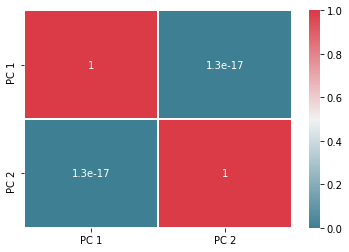

In [56]:
sns.heatmap(final_df.corr(), cmap=colormap,linewidth=1, annot=True)

The two PC have little to no correlation to one another which means the reduction in feature dimmentionality from 4 to 2 is appropriate.

## Interpreting PCA

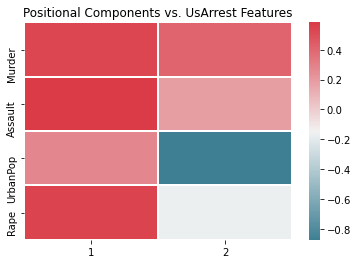

Text(0.5, 1.0, 'Correlation of UsAssault Features')

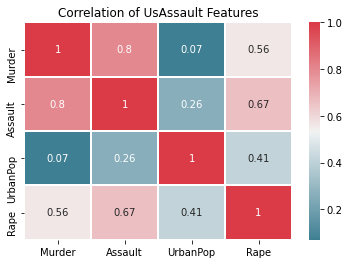

In [57]:
components = pd.DataFrame(pca.components_, columns=df.columns, index=range(1, n_comps+1)).transpose()
ax = sns.heatmap(components,cmap=colormap,linewidth=1)
plt.title("Positional Components vs. UsArrest Features")
plt.show()

sns.heatmap(df.corr(), cmap=colormap,linewidth=1, annot=True)
plt.title("Correlation of UsAssault Features")

As discussed earlier, PC1 is influened by 'Murder', 'Assault' and 'Rape' mainly. However, it also appears to suggest that 'UrbanPop' is a significant feature in influence PC1 also. PC2 is negatively dominated by 'UrbanPop' feature whilst both 'Murder' and 'Assault' influence PC2 postively but on a reduced scaler compared to 'UrbanPop'.

### Bi-Plot 

In [58]:
plt.style.use('ggplot')

def draw_vectors(transformed_features, components_, columns):
    """
    Projects original data onto the PC feature-space, enabling you
    to visualise each features importance in relations to each data point
    and PC.
    """
    num_columns = len(columns)
    
    x_vector = components_[0] * max(transformed_features[:,0])
    y_vector = components_[1] * max(transformed_features[:,1])
    
    ax = plt.axes()
    
    for i in range(num_columns):
        plt.arrow(0,0,x_vector[i], y_vector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75)
        plt.text(x_vector[i]*1.08, y_vector[i]*1.08, list(columns)[i], color='b', alpha=0.75)
        
    return ax

(-3.0, 3.0)

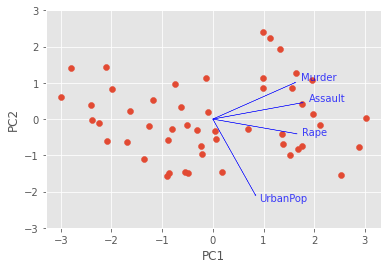

In [59]:
pca_t = pca.transform(X_std)

ax = draw_vectors(pca_t, pca.components_, df.columns[:].values)
trans_df = pd.DataFrame(pca_t)
trans_df.columns = ['PC1', 'PC2']

plt.scatter(trans_df['PC1'], trans_df['PC2'], alpha=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.ylim(-3, 3)

## Clustering Method 1 -  K-Means

### Selecting K
### Elbow Method

C:\Users\Georgia\anaconda32nd\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Georgia\anaconda32nd\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Georgia\anaconda32nd\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Georgia\anaconda32nd\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

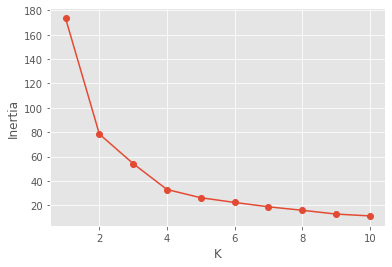

In [60]:
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(x)    
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(principal_components)

From this we can see that our k value should be between 2 - 4. To decide which K value is the best, we will evaluate the silhoutte scores.

### Silhoutte Score

C:\Users\Georgia\anaconda32nd\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


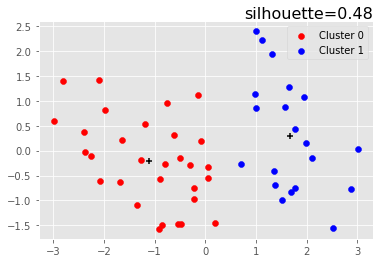

silhouette score 0.48 with K = 2


C:\Users\Georgia\anaconda32nd\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


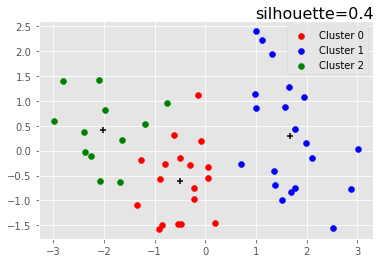

silhouette score 0.4 with K = 3


C:\Users\Georgia\anaconda32nd\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


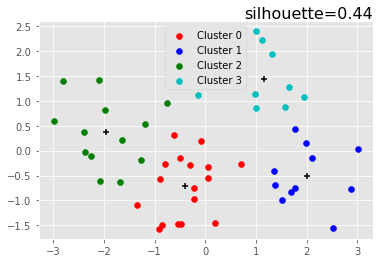

silhouette score 0.44 with K = 4


In [63]:
def check_silhouette_score(x, k):
    kmeans = KMeans(n_clusters=k, n_init=10, init='k-means++', random_state=123)
    y_pred = kmeans.fit_predict(x)

    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='+', c = 'black')

    score = round(silhouette_score(x, kmeans.labels_, metric='euclidean'),2)

    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.legend()
    plt.show()

    return score

for k in range(2, 5):
    print(f"silhouette score {check_silhouette_score(principal_components, k)} with K = {k}")

## Clustering Method 2 -  Aggrogate Hierarchical Clustering (AHC)

### Clustering
#### Distance metric: Euclidean

Optimum silhoutte score is achieved when K=2

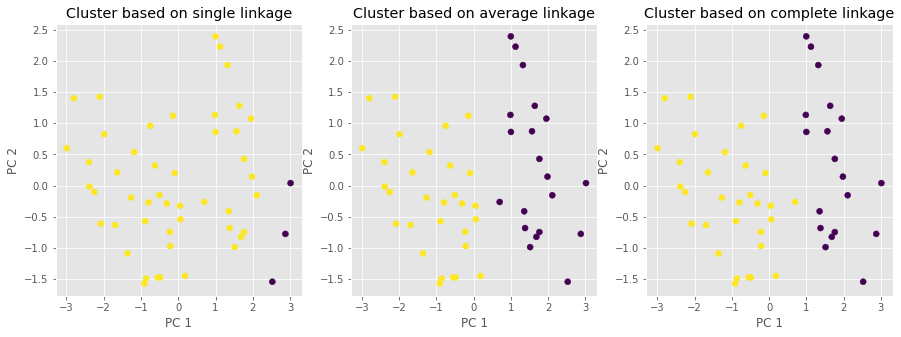

In [65]:
K = 2

plt.figure(figsize=[15,5])

linkage_types = ['single', 'average', 'complete']

for i, l in enumerate(linkage_types):
    plt.subplot(1, 3, i+1)
    
    cluster1 = AgglomerativeClustering(n_clusters=K, metric='euclidean', linkage=l)
    cluster1.fit_predict(principal_components)
    
    ax = plt.scatter(principal_components[:,0], principal_components[:,1], c=cluster1.labels_)
    
    plt.title('Cluster based on {} linkage'.format(l))
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')

#### Distance metric: Cityblock

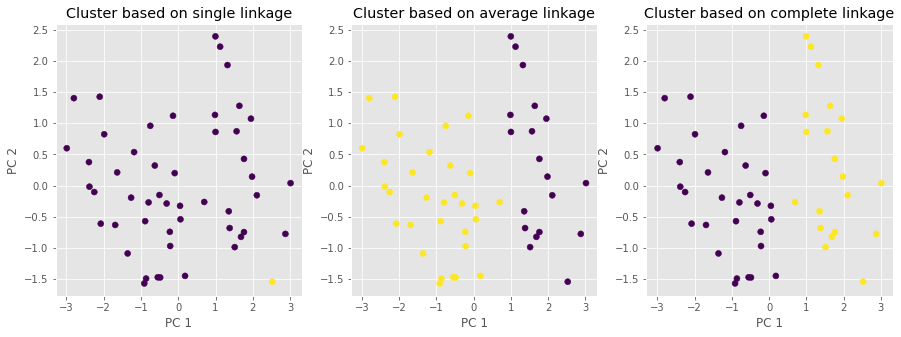

In [69]:
plt.figure(figsize=[15,5])

for i, l in enumerate(linkage_types):
    plt.subplot(1, 3, i+1)
    
    cluster2 = AgglomerativeClustering(n_clusters=K, metric='cityblock', linkage=l)
    cluster2.fit_predict(principal_components)
    
    ax = plt.scatter(principal_components[:,0], principal_components[:,1], c=cluster2.labels_)
    
    plt.title('Cluster based on {} linkage'.format(l))
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')

Both the average and complete linkage methods for both the Euclidean and Cityblock distance metrics where able to split the data into two distinctive groups. To decide which method is best, we will use dendrograms to determine which method split the groups most clearly.

## Visualisations

### Dendrograms

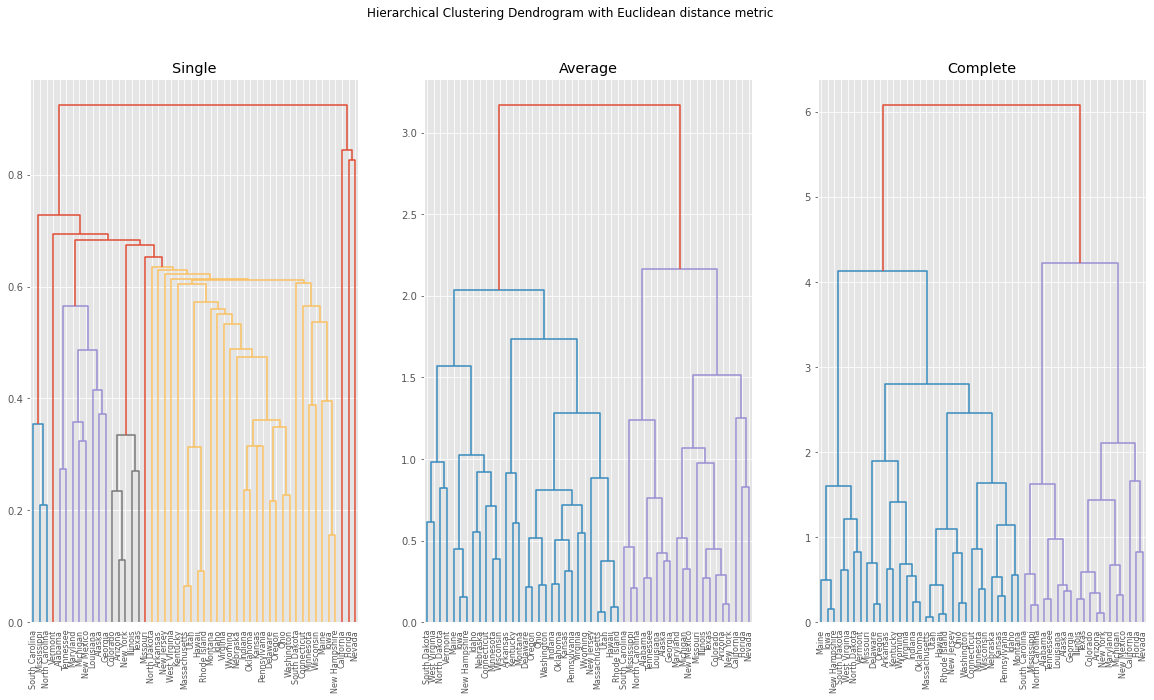

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,10))
fig.suptitle('Hierarchical Clustering Dendrogram with Euclidean distance metric')
ax1.set_title("Single")  
dend1 = dendrogram(linkage(principal_components, method='single', metric="euclidean"), labels=df.index, ax=ax1)
ax2.set_title("Average")  
dend1 = dendrogram(linkage(principal_components, method='average', metric="euclidean"), labels=df.index, ax=ax2)
ax3.set_title("Complete")  
dend1 = dendrogram(linkage(principal_components, method='complete', metric="euclidean"), labels=df.index, ax=ax3)

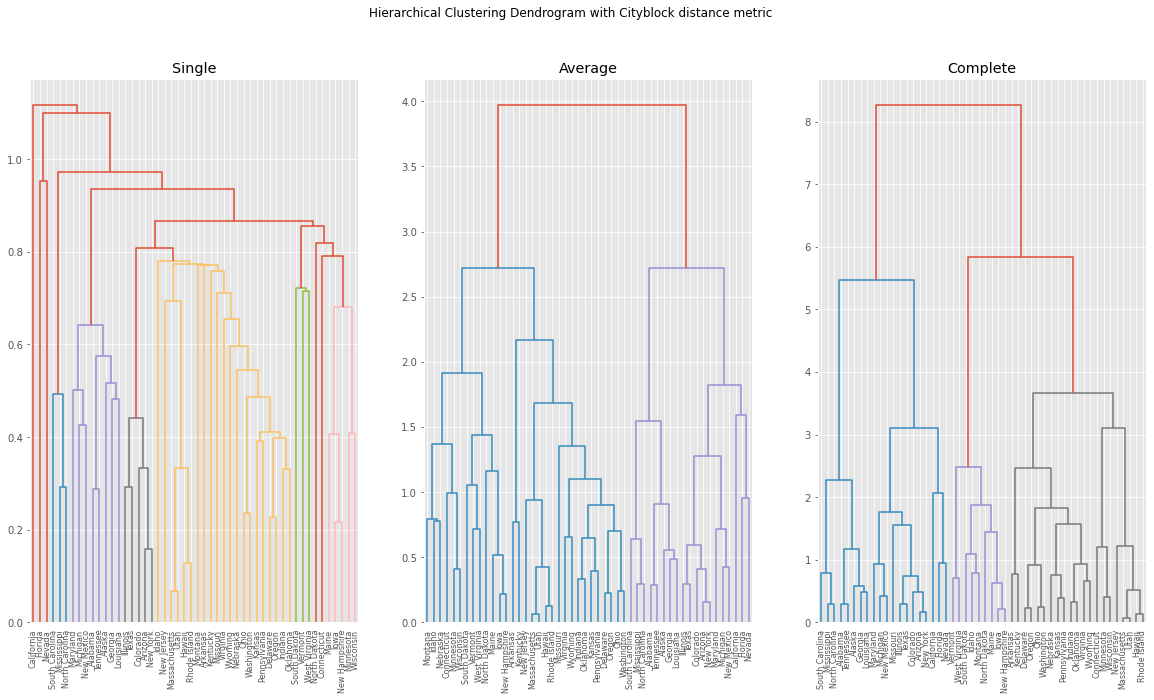

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,10))
fig.suptitle('Hierarchical Clustering Dendrogram with Cityblock distance metric')
ax1.set_title("Single")  
dend1 = dendrogram(linkage(principal_components, method='single', metric="cityblock"), labels=df.index, ax=ax1)
ax2.set_title("Average")  
dend1 = dendrogram(linkage(principal_components, method='average', metric="cityblock"), labels=df.index, ax=ax2)
ax3.set_title("Complete")  
dend1 = dendrogram(linkage(principal_components, method='complete', metric="cityblock"), labels=df.index, ax=ax3)

From examining the dendrogram the best method appears to be a Euclidean complete clustering parameters.

## AHC @ Linkage='complete, Dis.Metric='euclidean' where k=2

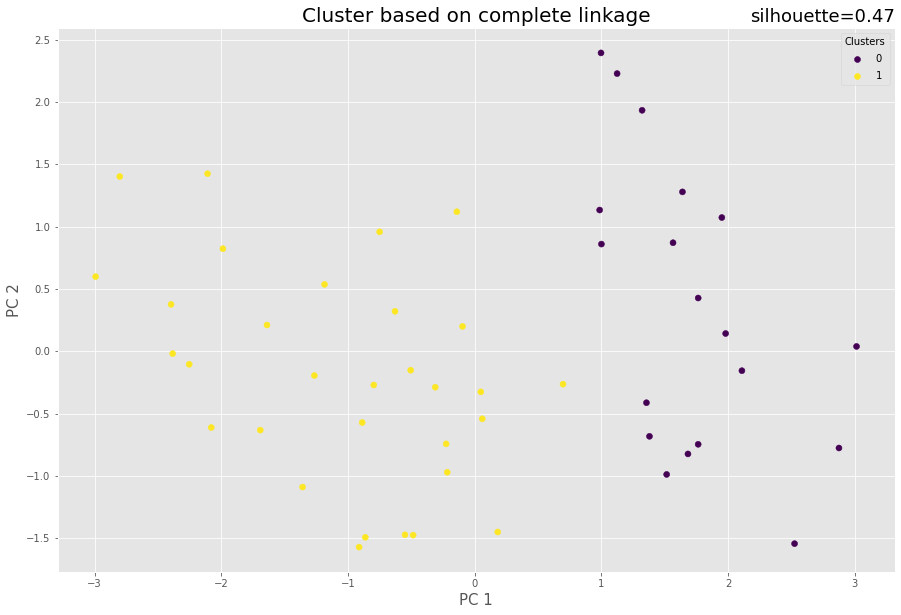

In [88]:
plt.figure(figsize=[15,10])

cluster3 = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='complete')
cluster3.fit_predict(principal_components)
    
ax = plt.scatter(principal_components[:,0], principal_components[:,1], c=cluster3.labels_)

score = round(silhouette_score(principal_components, cluster3.labels_, metric='euclidean'),2)
plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 18}, pad=-14)
plt.title('Cluster based on {} linkage'.format(l), fontsize=20)
plt.xlabel('PC 1', fontsize=15)
plt.ylabel('PC 2', fontsize=15)
plt.legend(*ax.legend_elements(), title="Clusters")

The k-means clustering method was able to achieve a marginally higher silhoutte score of 0.48 in comparison to the agglomerative hierarchical clustering model silhoutte score of 0.47. Thus the kmeans model was able to cluster similar data points together in comparision to other clusters marginally better than the AHC model. 

## Conclusion

C:\Users\Georgia\anaconda32nd\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Georgia\anaconda32nd\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0, 0.5, 'PC 2')

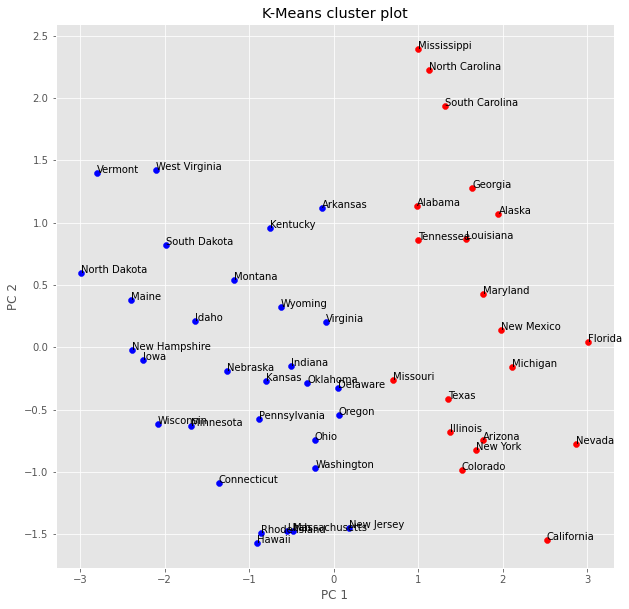

In [98]:
# We extract the first two components
x = principal_components[:,0]
y = principal_components[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=123)
cluster_labels = kmeans.fit_predict(principal_components)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots(figsize=(10,10))
colours = ['blue','red']
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

It would appear that the traditionally Souther States excluding 'New York', 'Nevada', 'Colorado', 'Missouri', and 'Illinois' make up cluster the red cluster and the other traditionally Northen States make up the blue cluster. 

States in the red cluster appear to have higher murders, assults and rapes in comparison to the States in the blue custer. This seems plausible as given the political history and the period in which the data was collected (1973).